# Statistical paradoxes and causality.

**Author**: *Javier Gonzalez (jagonz@microsoft.com)*


The goal of this notebook is to provide a general intuition to why we need causal inference in data science. We will cover the two main statistical paradoxes that can be resolved using causality: the Simpsons paradox and the Berskon paradox.

In [8]:
import numpy as np
import pandas as pd
import dowhy
import seaborn as sns

## 1. Data generation

We don't use any real data in this example, instead we generate some data that represents how a therapy works.

- BMI, which represents the patient characteristics.
- age, represents the age of the patient.
- dose representing the product.
- response, represents the days of response of the patient.

We assume that all variables are linearly related, with a causal structure that agrees with what we know about the therapy (see below). To make things simpler, the response is not a binary variable but a probability of response.

In [27]:
## Data generation process

num_samples = 1000
TRUE_EFFECT_DOSE_PRESEPONSE = -1.5
np.random.seed(123)

## patient
bmi = np.random.normal(2,0.25,num_samples)
age = np.random.normal(50,10,num_samples)

dose = .1*age+ np.random.normal(0,.1,num_samples)
days_response= .5 + .1*bmi + TRUE_EFFECT_DOSE_PRESEPONSE*dose  + .5* age + np.random.normal(0,5,num_samples)


data = np.vstack([bmi, age, dose, days_response]).T
df = pd.DataFrame(data, columns = ['BMI','AGE','DOSE','RESPONSE'])
df

,BMI,AGE,DOSE,RESPONSE
0,1.728592,42.511725,4.073750,13.565103
1,2.249336,55.675947,5.447457,23.439673
2,2.070745,57.181505,5.827776,26.424885
3,1.623426,40.006193,4.086723,18.894427
4,1.855350,54.748983,5.322862,29.599351
...,...,...,...,...
995,2.158691,58.457012,5.838168,16.647363
996,2.267480,38.800775,3.785458,5.358726
997,1.772668,46.407033,4.844746,15.999999
998,2.117566,33.903049,3.491897,21.397866


## 2. Impact of dose on probability of response

Let's look at the data we have generated with the intention of estimating the effect of dose on response. We start but simply looking at the scatterplot of these two variables.

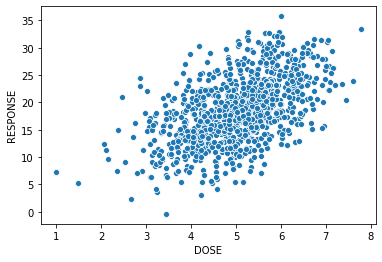

In [28]:
sns.scatterplot(x = 'DOSE', y = 'RESPONSE', data = df)

Indeed it looks like a larger dose increases the probability of response. To compute that effect, and because the relationships seems to be linear, let's run a linear regression model.

In [52]:
import numpy as np
import statsmodels.api as sm
X = df[['DOSE']]
y = df[['RESPONSE']]

X_int = sm.add_constant(X)
regression = sm.OLS(y, X_int).fit()
predictions = regression.predict(X_int) 
print_model = regression.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               RESPONSE   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     397.6
Date:                Sun, 20 Sep 2020   Prob (F-statistic):           1.01e-74
Time:                        20:00:01   Log-Likelihood:                -3020.4
No. Observations:                1000   AIC:                             6045.
Df Residuals:                     998   BIC:                             6055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2516      0.833      2.704      0.0

In [53]:
regression.params

const    2.251627
DOSE     3.255381
dtype: float64

The estimated coeffient is 3.25, but we know (because we have generated the data!) that the true effect is -1.5. This model is over-estimating the effect of dose on response and the reason why is doing it is because we are not taking into account any causal information.

So this model is telling me that when I increase dose in one unit, the days of points. But we know that this is wrong, because the true effect is 1.5 Let's see what do we get if we do a causal analysis of the problem.

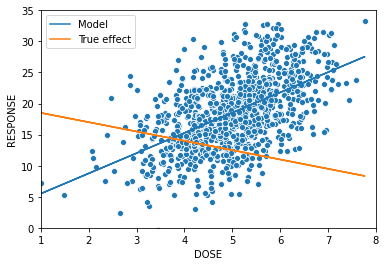

In [54]:
import matplotlib.pyplot as plt

sns.scatterplot(x = 'DOSE', y = 'RESPONSE', data = df)
plt.plot(X, regression.params['const'] +X*regression.params['DOSE'], label = 'Model')
plt.plot(X, 20 +X*TRUE_EFFECT_DOSE_PRESEPONSE, label = 'True effect')
plt.xlim(1,8)
plt.ylim(0,35)
plt.legend()

## 5. Estimating the effect controling by age

In [56]:
import numpy as np
import statsmodels.api as sm
X = df[['AGE','DOSE']]
y = df[['RESPONSE']]

X_int = sm.add_constant(X)
regression = sm.OLS(y, X_int).fit()
predictions = regression.predict(X_int) 
print_model = regression.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               RESPONSE   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     204.1
Date:                Sun, 20 Sep 2020   Prob (F-statistic):           4.96e-75
Time:                        20:00:14   Log-Likelihood:                -3016.4
No. Observations:                1000   AIC:                             6039.
Df Residuals:                     997   BIC:                             6054.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0522      0.833      2.464      0.0

The estimated effect is now -1.2, much closer to the true effect.

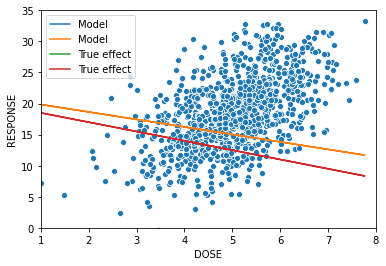

In [62]:
import matplotlib.pyplot as plt

sns.scatterplot(x = 'DOSE', y = 'RESPONSE', data = df)
plt.plot(X,19 +regression.params['const'] +X*regression.params['DOSE'], label = 'Model')
plt.plot(X, 20 +X*TRUE_EFFECT_DOSE_PRESEPONSE, label = 'True effect')
plt.xlim(1,8)
plt.ylim(0,35)
plt.legend()

Let's see what happens if we also include BMI.

In [63]:
import numpy as np
import statsmodels.api as sm
X = df[['AGE','DOSE','BMI']]
y = df[['RESPONSE']]

X_int = sm.add_constant(X)
regression = sm.OLS(y, X_int).fit()
predictions = regression.predict(X_int) 
print_model = regression.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               RESPONSE   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     136.2
Date:                Sun, 20 Sep 2020   Prob (F-statistic):           6.10e-74
Time:                        20:03:06   Log-Likelihood:                -3016.2
No. Observations:                1000   AIC:                             6040.
Df Residuals:                     996   BIC:                             6060.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9961      1.521      1.970      0.0

The result is not heavilty affected. Indeed including or not BMI does not affect the way we block the backdoor paths, only age is really important.

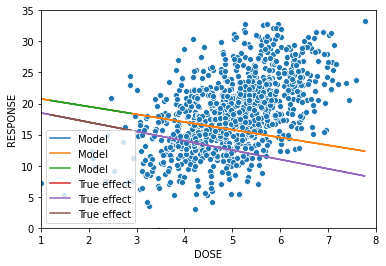

In [64]:
import matplotlib.pyplot as plt

sns.scatterplot(x = 'DOSE', y = 'RESPONSE', data = df)
plt.plot(X,19 +regression.params['const'] +X*regression.params['DOSE'], label = 'Model')
plt.plot(X, 20 +X*TRUE_EFFECT_DOSE_PRESEPONSE, label = 'True effect')
plt.xlim(1,8)
plt.ylim(0,35)
plt.legend()

## Is adding all the variables we have just enough?

One could think that just adding all variables is enough to block all back-door paths. This example shows that this is indeed the an wrong strategy that can lead to biased results too. 

In [78]:
num_samples = 1000
TRUE_EFFECT_DOSE_PRESEPONSE = -1.5
np.random.seed(123)

## patient
bmi = np.random.normal(2,0.25,num_samples)
age = np.random.normal(50,10,num_samples)
dose = .1*age+ np.random.normal(0,.1,num_samples)
days_response = .5 + .1*bmi + TRUE_EFFECT_DOSE_PRESEPONSE*dose  + .5* age + np.random.normal(0,5,num_samples)
activity_first = 2.5*days_response + 2 *dose + np.random.normal(0,2,num_samples)

data = np.vstack([bmi, age, dose, days_response,activity_first]).T
df = pd.DataFrame(data, columns = ['BMI','AGE','DOSE','RESPONSE', 'ACTIVITY'])
df

,BMI,AGE,DOSE,RESPONSE,ACTIVITY
0,1.728592,42.511725,4.073750,13.565103,41.117707
1,2.249336,55.675947,5.447457,23.439673,71.662242
2,2.070745,57.181505,5.827776,26.424885,76.959318
3,1.623426,40.006193,4.086723,18.894427,54.684967
4,1.855350,54.748983,5.322862,29.599351,83.281960
...,...,...,...,...,...
995,2.158691,58.457012,5.838168,16.647363,51.050201
996,2.267480,38.800775,3.785458,5.358726,18.130455
997,1.772668,46.407033,4.844746,15.999999,45.970060
998,2.117566,33.903049,3.491897,21.397866,62.306103


Let's assume that we have observed the kms. walked by the patient after the dose has been suminstrated. This is expected to be affected by both the dose, and the days of response. Indeed in our data we see how it is highly correlated with activity, so it seems a good idea to include it as regressor.

array([[1.        , 0.98730495],
       [0.98730495, 1.        ]])

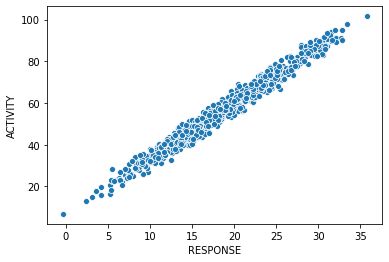

In [79]:
sns.scatterplot(x = 'RESPONSE', y = 'ACTIVITY', data = df)
np.corrcoef(df['RESPONSE'],df['ACTIVITY'])

Indeed both variables are highly correlated. So, what about including ACTIVITY as predictor in the regression model that aims to explain RESPONSE with DOSE? Let's see what happens.

In [80]:
import numpy as np
import statsmodels.api as sm
X = df[['BMI', 'AGE','ACTIVITY','DOSE']]
y = df[['RESPONSE']]

X_int = sm.add_constant(X)
regression = sm.OLS(y, X_int).fit()
predictions = regression.predict(X_int) 
print_model = regression.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               RESPONSE   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.353e+04
Date:                Sun, 20 Sep 2020   Prob (F-statistic):               0.00
Time:                        20:14:46   Log-Likelihood:                -1180.8
No. Observations:                1000   AIC:                             2372.
Df Residuals:                     995   BIC:                             2396.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0284      0.243     -0.117      0.9

Now the effect of DOSE is statistically significant but way smaller that it should be! This is because response is a collider. Including colliders to control for causal effect has bad consequences in the estimates. The reason is because in X->C<-Y X and Y and independent but X and Y and dependent given C. Now lets identify the effect of DOSE on RESPONSE by avoinding controlling by activity.

In [83]:
import numpy as np
import statsmodels.api as sm
X = df[['DOSE', 'AGE']]
y = df[['RESPONSE']]

X_int = sm.add_constant(X)
regression = sm.OLS(y, X_int).fit()
predictions = regression.predict(X_int) 
print_model = regression.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               RESPONSE   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     204.1
Date:                Sun, 20 Sep 2020   Prob (F-statistic):           4.96e-75
Time:                        20:16:38   Log-Likelihood:                -3016.4
No. Observations:                1000   AIC:                             6039.
Df Residuals:                     997   BIC:                             6054.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0522      0.833      2.464      0.0

It works!